In [1074]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import datetime as dt
import scipy.stats as ss
import sklearn.metrics as metrics

## Introduction

The novel coronavirus SARS-CoV-2 pandemic has presented New Zealand with a major public health crisis since its arrival at the start of 2020. Until the introduction of Rapid Antigen Testing (RATs), a key tool used to monitor and manage the spread of the virus has been PCR testing. Using this, a extensive public health infrastructure was established to find confirmed cases of COVID-19 and identify potential close contacts of the virus. 

Prior to RAT testing, public PCR testing stations were made available to the general population, and the public was ecouraged to get tested if they were a contact (or a suspected contact) of a COVID-19 case, or had COVID-19 symptoms. Prior to widely available RAT testing, public PCR testing stations would become innudated at times of high public concern about potential outbreaks. In this report, the correlation between COVID-19 tests (prior to RAT testing) and cases are examined to investigate potential changes in the public perceptions of the pandemic and the testing infrastructure as a whole.

### Data

The number of test results returned and the daily case numbers were taken from the Stats NZ covid portal (link). From this, a dataset was created that tracks the number of active cases and the number of tests results.

In [1075]:
path = 'c:/Users/callu/Documents/Stats NZ/'
metadata = pd.read_excel(path+'/covid_19_data_portal.xlsx', sheet_name=0)
data = pd.read_excel(path+'/covid_19_data_portal.xlsx', sheet_name=1)
metadata

,ResourceID,Subject,Title,Description,Notes,Caveats,Source,SourceURL,Modified,Frequency,Var1,Var2,Var3
0,CPCOV1,COVID-19,Testing period,COVID-19 test results delivered in past 24 hou...,NaN,NaN,Ministry of Health,https://www.health.govt.nz/our-work/diseases-a...,2022-09-18T12:00:00Z,Daily,NaN,NaN,NaN
1,CPCOV2,COVID-19,Number of Cases,COVID-19 cases in New Zealand (cumulative),NaN,NaN,Ministry of Health,https://www.health.govt.nz/our-work/diseases-a...,2022-09-18T12:00:00Z,Daily,Case status,NaN,NaN


In [1076]:
# Convert timestamp into datetime object
data.Period = pd.to_datetime(data.Period, format='%Y-%m-%d')

model_data = pd.DataFrame()
# Index dataframe by timeseries 
model_data.index = pd.date_range(min(data.Period), max(data.Period))

model_data['Test_Results']=np.nan
model_data['Active_Cases']=np.nan

# Read in data from Stats NZ
for i, x in data[data.ResourceID=='CPCOV1'].Value.items():
    t = data.Period.loc[i]
    model_data['Test_Results'].loc[t] = x
for i, x in data[np.logical_and(data.ResourceID=='CPCOV2', data.Label1=='Active')].Value.items():
    t = data.Period.loc[i]
    model_data['Active_Cases'].loc[t] = x
# model_data['d_Active_Cases'] = np.append(np.diff(model_data['Active_Cases']),np.nan) # Calculate rate of change in daily cases (central difference)

### Cases and Testing Rates
From about Febuary 2022, RAT tests become widely available to the public (e.g. __[link](https://www.beehive.govt.nz/release/government-secures-extra-36-million-rapid-antigen-tests)__ ), which displaces the reported PCR lab testing rats. The timeseries in figure b. (below) shows a clear discontinuity at the point at which RAT testing is made __[available for free to the public](https://www.health.govt.nz/news-media/media-releases/free-rapid-antigen-tests-now-available-home-testing)__. Prior to this, testing rates and daily case number show a weak positive association (Pearson's R = 0.66). As expected, testing rates spike around outbreaks of the virus, when many possible contacts are identified and when public concern is high.

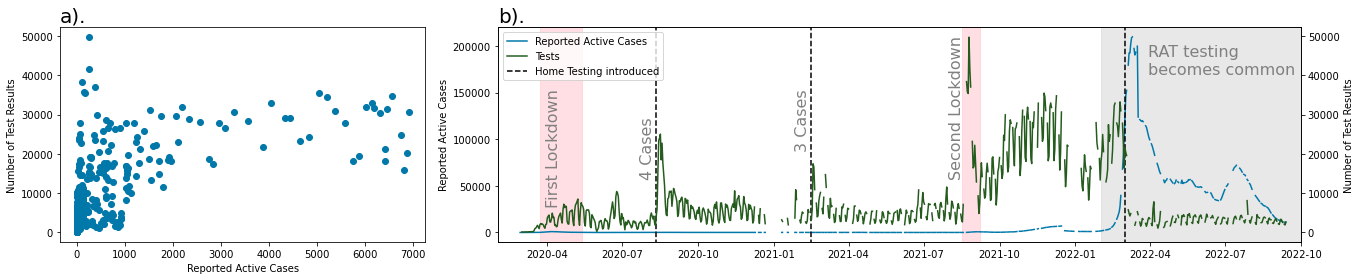

,Active_Cases,Test_Results
Active_Cases,1.000000,0.628739
Test_Results,0.628739,1.000000


In [1077]:
RAT_tests = dt.datetime(year=2022,month=2, day=1) # RAT testing becomes common in Feb '22
home_RAT_tests = dt.datetime(year=2022,month=3, day=2) # RAT testing made available for free from 2/03/2022

first_lockdown = [dt.datetime(year=2020,month=3, day=23),dt.datetime(year=2020,month=5, day=13)] # 23 March 2020 - 13 May 2020
second_lockdown = [dt.datetime(year=2021,month=8, day=17),dt.datetime(year=2021,month=9, day=7)] # 17 August 2021 - 7 September 2021

fig = plt.figure(figsize=(19,4))
gs = plt.GridSpec(1, 3, figure=fig)
ax1 = fig.add_subplot(gs[0, :1])
ax2 = fig.add_subplot(gs[0, 1:])
ax2_2 = ax2.twinx()

# ---------------------ax1----------------------------
ax1.scatter(model_data['Active_Cases'][:RAT_tests],model_data['Test_Results'][:RAT_tests],color='#0078aa')

ax1.set_xlabel('Reported Active Cases')
ax1.set_ylabel('Number of Test Results')
ax1.set_title('a).',loc='left',size=20)

# ---------------------ax2----------------------------
l1 = ax2.plot(model_data['Active_Cases'],label='Reported Active Cases',color='#0078aa')
l2 = ax2_2.plot(model_data['Test_Results'],label='Tests', color='#255c1e')
l3 = ax2.plot([home_RAT_tests,home_RAT_tests],[-22222,220000], 
              color='k',label='Home Testing introduced',linestyle='dashed')


ax2.axvspan(RAT_tests,dt.datetime(year=2022,month=10,day=1),color='lightgray', alpha=0.5)
ax2.text(dt.datetime(2022, 3, 30), 170000, 'RAT testing \nbecomes common', fontsize=16, color='gray')

ax2.axvspan(first_lockdown[0],first_lockdown[1],color='pink', alpha=0.5)
ax2.text(dt.datetime(2020, 3, 30), 30000, 'First Lockdown', fontsize=16, color='gray',rotation='vertical')

ax2.axvspan(second_lockdown[0],second_lockdown[1],color='pink', alpha=0.5)
ax2.text(dt.datetime(2021, 8, 1), 60000, 'Second Lockdown', fontsize=16, color='gray', rotation='vertical')

ax2.plot([dt.datetime(year=2020,month=8, day=11),dt.datetime(year=2020,month=8, day=11)],[-22222,220000], 
              color='k',linestyle='dashed')
ax2.text(dt.datetime(2020, 7, 22), 60000, '4 Cases', fontsize=16, color='gray', rotation='vertical')

ax2.plot([dt.datetime(year=2021,month=2, day=14),dt.datetime(year=2021,month=2, day=14)],[-22222,220000], 
              color='k',linestyle='dashed')
ax2.text(dt.datetime(year=2021,month=1, day=26), 90000, '3 Cases', fontsize=16, color='gray', rotation='vertical')


ax2.set_ylabel('Reported Active Cases')
ax2_2.set_ylabel('Number of Test Results')
ax2.set_title('b).',loc='left',size=20)
ax2.set_ylim(-10000,220000)
ax2.set_xlim(dt.datetime(year=2020,month=2,day=1),dt.datetime(year=2022,month=10,day=1))

lns = l1+l2+l3
labs = [l.get_label() for l in lns]
ax2.legend(lns, labs, loc='upper left')


fig.tight_layout()
plt.show()
model_data[['Active_Cases','Test_Results']].loc[:RAT_tests].corr()

A simple model for the rate of testing might be built from as a simple linear association between the reported daily cases and the testing rates, or:

$T(t_i) = a \cdot I(t_i)$

where $T(t_i)$ and $I(t_i)$ are the testing rate and the number of infected people respectively. This model is based around the assumption that the number of exposed contacts, and the degree of public concern about the virus are directly proportional to the number of active cases in the community.

This basic model was fit to the model using non-linear least squares. This linear association is rather poor at estimating testing rates ($R^2=-0.05$). It significantly underestimates the testing rates for very low case numbers and over estimates testing rates at very high case numbers. Furthermore, it does not capture the initial spike in testing when case numbers initially surge at the start of an outbreak.

For modelling purposes, gaps in the dataset were linearly interpolated.

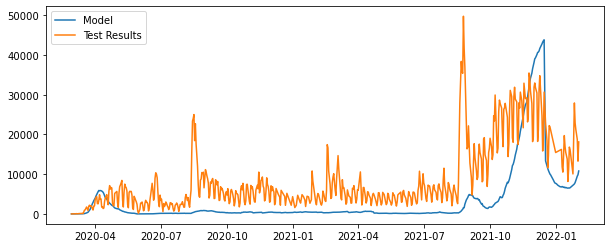

R squared = -0.05
MSE = 75027202.47


In [1089]:
import scipy.optimize as opt

model_data = model_data.interpolate()
model_data = model_data.fillna(0) # the remaining NaNs at the start of the dataset are filled with 0s

f = lambda X,a: a*X # The model
x_0 = np.array(model_data['Active_Cases'][:RAT_tests])
y = np.array(model_data['Test_Results'][:RAT_tests])
p0 = [8] # Starting values

# Fit model 
popt, pcov = opt.curve_fit(f, x_0, y,p0)
pred = [f(x_0[i],popt[0]) for i in range(len(x_0))]

# Plot
fig = plt.figure(figsize = (10,4))
plt.plot(model_data['Test_Results'][:RAT_tests].index,pred,label='Model')
plt.plot(model_data['Test_Results'][:RAT_tests].index,y,label='Test Results')
plt.legend()
plt.show()
print('R squared = {0:.2f}'.format(metrics.r2_score(y,pred)))
print('MSE = {0:.2f}'.format(metrics.mean_squared_error(y,pred)))

### An Alternate Model
One explaination for the weak perfromance of the above model is that the association between testing rates and case rates is non-linear. From the start of the COVID-19 pandemic in NZ at the beginning of 2020, until to arrival of the delta variate in 2021, COVID-19 case numbers remained very low in NZ. There was a great deal of public effort expended in keeping COVID-19 out of the community through lockdowns and border closures. In this sense, at very low case numbers community concern is relatively high. As case numbers increase, people's sensitivty to case numbers might be expected to decrease, as the idea of being able to fully prevent the spread of the disease appears less and less realsitic. Similarly, when case numbers and testing rates are very high, the PCR lab testing capacity of the country becomes saturated. Another important factor in the public's percetion of the danger of the pandemic is the rate of new cases. When cases are increasing rapidly, there is additional concern in the public and government about a rapidly growing outbreak. These two factors can be modelled as follows:

$T(t_i) = a Y_i + b Z_i$


where $Y_i = \log{(I_i+1)}$ is a function that represents the saturation of public concern and testing capacity at high case numbers, and $Z_i$ is given by:
$\frac{1}{\bar{N_{i,n}}+1}\left[ \frac{|dI(t_i)|-dI(t_I)}{2} \right]^2$ 

Which is a fucntion of the positive component of the derivative of the daily number of active case and $\bar{N_{i,n}}$, the mean number of active cases in the last $n$ days:

$\bar{N_{i,n}} = \frac{1}{n}\sum \limits _{j=i-n-1} ^{i-1} I_{j} $

This is such that the rate of change in cases is modified to be inversely proportional to the past case numbers, exaggerating sudden, smaller increases in active cases numbers when the past $n$ steps have had little or no new cases of COVID-19. The figure below shows the response of $Y_i$ and $Z_i$ to the daily active cases.

In [1083]:
def N_i(X, n):
    # Function for N_i,n, see markdown above
    out = []
    for i, x in enumerate(X[:-n]):
        out.append(abs(np.nansum(X[i:i+n])))
    return np.array(out)/n

model_data['log_Active_Cases'] = np.log(model_data['Active_Cases']+1)

n = 3 
model_data['d_Active_Cases']=np.gradient(model_data['Active_Cases']) # Derviative of active cases (central limit)
model_data['d_Active_Cases'] = (abs(model_data['d_Active_Cases'])+model_data['d_Active_Cases'])/2 # Take only positive component
model_data['N_i_Active_Cases'] = 0

pd.options.mode.chained_assignment = None
model_data['N_i_Active_Cases'].loc[min(model_data.index)+dt.timedelta(days=n):] = N_i(model_data['Active_Cases'].tolist(),n)
model_data['mod_d_Active_Cases'] = model_data['d_Active_Cases']**2/(model_data['N_i_Active_Cases']+1)

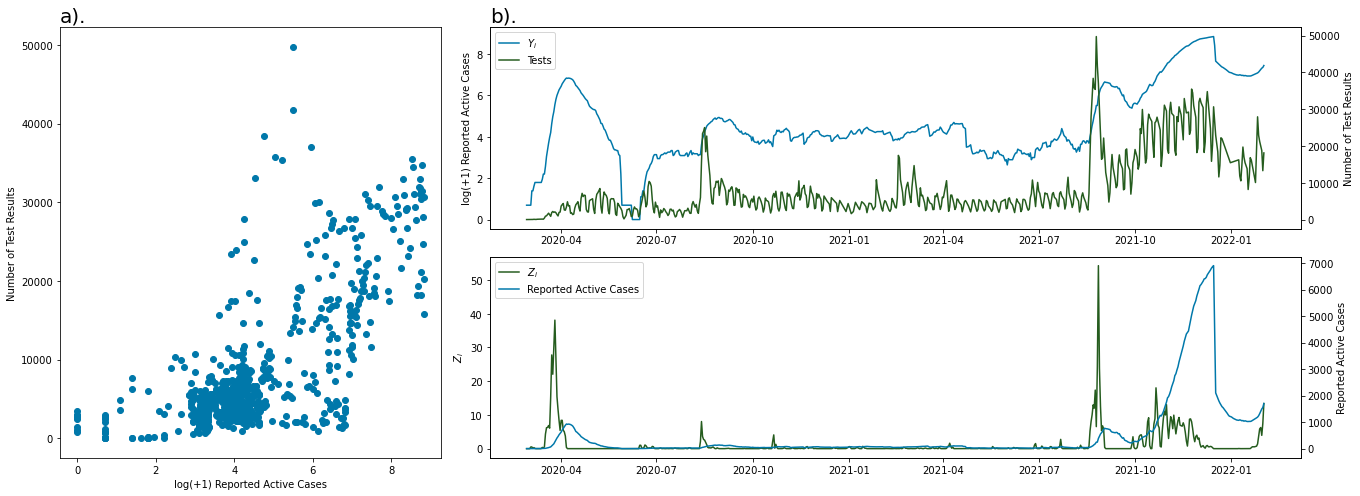

,log_Active_Cases,Test_Results,mod_d_Active_Cases
log_Active_Cases,1.000000,0.716100,0.278062
Test_Results,0.716100,1.000000,0.394998
mod_d_Active_Cases,0.278062,0.394998,1.000000


In [1086]:
fig = plt.figure(figsize=(19,7))
gs = plt.GridSpec(2, 3, figure=fig)
ax1 = fig.add_subplot(gs[:, :1])
ax2 = fig.add_subplot(gs[0, 1:])
ax2_2 = ax2.twinx()

ax3 = fig.add_subplot(gs[1, 1:])
ax3_2 = ax3.twinx()
# ---------------------ax1----------------------------
ax1.scatter(model_data['log_Active_Cases'][:RAT_tests], model_data['Test_Results'][:RAT_tests],color='#0078aa')
ax1.set_xlabel('log(+1) Reported Active Cases')
ax1.set_ylabel('Number of Test Results')
ax1.set_title('a).',loc='left',size=20)

# ---------------------ax2----------------------------
l1 = ax2.plot(model_data['log_Active_Cases'][:RAT_tests],label='$Y_i$',color='#0078aa')
l2 = ax2_2.plot(model_data['Test_Results'][:RAT_tests],label='Tests', color='#255c1e')

ax2.set_ylabel('log(+1) Reported Active Cases')
ax2_2.set_ylabel('Number of Test Results')
ax2.set_title('b).',loc='left',size=20)

lns = l1+l2
labs = [l.get_label() for l in lns]
ax2.legend(lns, labs, loc='upper left')

# ---------------------ax3----------------------------

l1 = ax3.plot(model_data['Active_Cases'][:RAT_tests].index,model_data['mod_d_Active_Cases'][:RAT_tests], color='#255c1e',label='$Z_i$')
l2 = ax3_2.plot(model_data['Active_Cases'][:RAT_tests],label='Reported Active Cases',color='#0078aa')
lns = l1+l2
labs = [l.get_label() for l in lns]
ax3.legend(lns, labs, loc='upper left')

ax3_2.set_ylabel('Reported Active Cases')
ax3.set_ylabel('$Z_i$')
fig.tight_layout()
plt.show()
model_data[['log_Active_Cases','Test_Results','mod_d_Active_Cases']].loc[:RAT_tests].corr()

Fitting this model as before, we see that the model easily outpreforms the previous, linear model. Althouth does over predict testing rates at the start, and still fails to capture some of the spikes. The large gap between the model and the initial testing rate during the first lockdown might be explained by the limited PCR testing capacity in NZ at that time. 

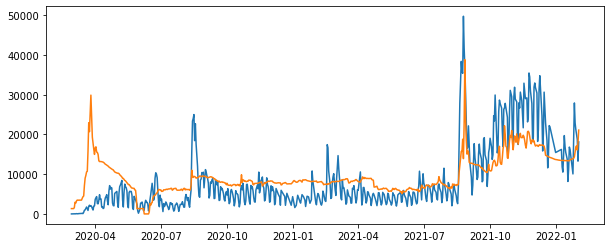

R squared = 0.49
MSE = 36644088.55


In [1087]:
f = lambda X,a,b: a*X[0]+ b*X[1]
x_0 =  np.array(model_data['mod_d_Active_Cases'][:kudu_RAT_tests])
x_1 =  np.array(model_data['log_Active_Cases'][:kudu_RAT_tests])
y = np.array(model_data['Test_Results'][:kudu_RAT_tests])
p0 = [100, 60]
popt, pcov = opt.curve_fit(f, (x_0,x_1), y,p0)
pred = [f([x_0[i],x_1[i]],popt[0],popt[1]) for i in range(len(x_0))]
fig = plt.figure(figsize = (10,4))
plt.plot(model_data[:kudu_RAT_tests].index,y)
plt.plot(model_data[:kudu_RAT_tests].index,pred)
plt.show()
print('R squared = {0:.2f}'.format(metrics.r2_score(y,pred)))
print('MSE = {0:.2f}'.format(metrics.mean_squared_error(y,pred)))


## Concluding Remarks

Using data provided by the Stats NZ COVID-19 data portal, we investigated the response of New Zealands PCR testing rates to active COvid-19 cases. Using this data, we found qualitative evidence that spikes in testing correlated with coomunity outbreaks. We showed that the testing rate response was not linearly correlated to the daily COVID case numbers. Our model suggests that at higher case numbers, the testing rate became saturated and the publics response to the pandemic slowed. We also showed that testing rates responded strongly to sudden increases in case numbers. One limitation of this data was that community cases and cases of COVID-19 in managed isolation were not separated. This might explain why our model over predicts the public's testing rate during periods where there was no community transmission, as the public's concern for cases in managed isolation would likley be much less than cases of transmission in the community. 

An important implication of the findings here suggest that the public's response to the pandemic is strongly correlated to overall case numbers. With higher case numbers engendering proportionately less effort by the public to test for and control the pandemic. Similarly, increases in case numbers from a very low baseline resulted in proportionately higher responses by the public than much larger changes during a period of widespread transimission. This may have important implications for public health management in the COVID-19 and furture pandemics going forward. 